# AI4Spec 3: Predicting spectral curves with NN methods

In these tutorials exercises, we review different AI approaches to predicting ground or excited state energy levels simply based on the atomic structure of materials. Here we focus on molecules and molecular orbitals, but the sample principles apply to crystal structures and electronic bands.

 We start by predicting individual states (Tutorial 1), proceed towards predicting multiple states at once (Tutorial 2) and finish by predicting entire spectral curves (Tutorial 3). The tutorials were prepared by Milica Todorović (University of Turku) and Kunal Ghosh (Aalto University).

<img src="https://raw.githubusercontent.com/milicasan/TutorialImages/89238bfff57a38ec78ecbd08765b63bd15ff9e2c/AI4spec.png" width="600px"/>

In the exercise below, our AI objective is to train a model to predict an entire spectral curve. We achieve this by discretising spectra on a grid, then learning the numbers at the same time. This is the most complex objective so far, because we are predicting many floating numbers at the same time. We deploy the same AI model as before, the CNN, but adjust the network architecture to the large output - the spectral curve.



## 1. Using neural networks to predict spectral curves


We proceed with the QM9 dataset of 132k molecules for spectral prediction. For the purposes of this tutorial, we take a subset of 7000 molecules, but in your own time you can try the entire dataset.

Detailed descriptions and results for a similar dataset (QM9) can be found in [K. Ghosh, et al. "Deep Learning Spectroscopy: Neural Networks for Molecular Excitation Spectra." Adv. Sci. 6 1801367 (2019)](https://onlinelibrary.wiley.com/doi/full/10.1002/advs.201801367).

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import math, random
from scipy.sparse import load_npz
from matplotlib.colors import LinearSegmentedColormap
import time

### Load and visualize data

First, we load the data. The molecules are represented by their Coulomb matrices, which were computed with the [Dscribe](https://www.sciencedirect.com/science/article/pii/S0010465519303042?via%3Dihub) package. The output data y is a matrix that contains the corresponding spectral curves for all molecules.

In [2]:
!wget https://zenodo.org/records/10069732/files/coulomb_7000.npz
!wget https://zenodo.org/records/10069732/files/spectra_7000.npz

--2024-03-04 21:47:36--  https://zenodo.org/records/10069732/files/coulomb_7000.npz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47096264 (45M) [application/octet-stream]
Saving to: ‘coulomb_7000.npz.3’

coulomb_7000.npz.3  100%[===================>]  44.91M  43.4MB/s    in 1.0s    

2024-03-04 21:47:38 (43.4 MB/s) - ‘coulomb_7000.npz.3’ saved [47096264/47096264]

--2024-03-04 21:47:38--  https://zenodo.org/records/10069732/files/spectra_7000.npz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16800264 (16M) [application/octet-stream]
Saving to: ‘spectra_7000.npz.1’

spectra_7000.npz.1  100%[===================>]  16.02M  27.7MB/s    in 0.6s    

202

In [3]:
# Here we load all the data
x = np.abs(np.load("coulomb_7000.npz")['arr_0'])
y = np.load("spectra_7000.npz")['arr_0']

## let's shuffle the data immediately
c = list(zip(x, y))
random.shuffle(c)
x, y = zip(*c)
x = np.array(x)
y = np.array(y)

As usual, let us check data size and the array lengths.

In [4]:
print("Number of molecules:", len(y))
print(x.shape)
print(y.shape)

Number of molecules: 7000
(7000, 29, 29)
(7000, 300)


The above confirms the 29x29 size of the Coloumb matrix. The spectral values are discretised on a grid of 300 entries, originally in the energy range [-30, 0]eV. Let us review one spectrum entry, e.g. for the 500th molecule:

In [5]:
print(y[500,:])

[3.04832655e-50 3.06806541e-49 3.01570308e-48 2.89489880e-47
 2.71393245e-46 2.48476615e-45 2.22173804e-44 1.94008617e-43
 1.65451241e-42 1.37797038e-41 1.12080633e-40 8.90311753e-40
 6.90676183e-39 5.23272240e-38 3.87170047e-37 2.79767105e-36
 1.97429655e-35 1.36065796e-34 9.15812126e-34 6.01983591e-33
 3.86441500e-32 2.42272269e-31 1.48335295e-30 8.86964285e-30
 5.17950923e-29 2.95387378e-28 1.64519016e-27 8.94872406e-27
 4.75364755e-26 2.46611708e-25 1.24945682e-24 6.18229421e-24
 2.98743827e-23 1.40983754e-22 6.49770612e-22 2.92463671e-21
 1.28559645e-20 5.51897315e-20 2.31383714e-19 9.47388692e-19
 3.78830135e-18 1.47938690e-17 5.64208946e-17 2.10145037e-16
 7.64397590e-16 2.71544189e-15 9.42069175e-15 3.19187739e-14
 1.05616263e-13 3.41300286e-13 1.07711944e-12 3.31980474e-12
 9.99269925e-12 2.93747957e-11 8.43313118e-11 2.36442237e-10
 6.47416495e-10 1.73127204e-09 4.52137115e-09 1.15318456e-08
 2.87244641e-08 6.98763623e-08 1.66010220e-07 3.85182633e-07
 8.72825255e-07 1.931605

Seeing 300 entries does not tell us much, so next we plot the spectra of two random molecules in the dataset (500 and 1500). This is the type of data we will be predicting.

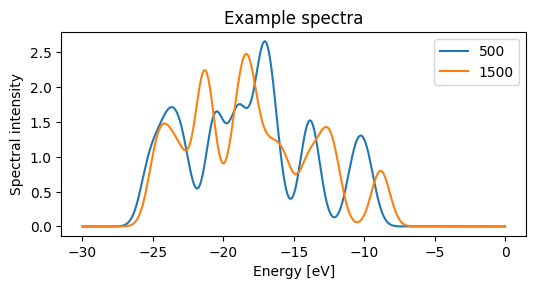

In [6]:
# first we generate the energy x-axis in the range [-30, 0]eV
x_ticks = np.linspace(0,-30, 300)

plt.figure(1, figsize=(6,9))
plt.subplot(311)
plt.plot(x_ticks, y[500,:], label='500') # Molecule from training set
plt.plot(x_ticks, y[1500,:], label='1500') # Molecule from training set
plt.title("Example spectra")
plt.xlabel("Energy [eV]")
plt.ylabel("Spectral intensity")
plt.legend()
plt.show()


Now, we divide the data into training and test set.

In [7]:
# decide how many samples to take from the database for training, testing and validation
n_train = 2000
n_test = 500
n_val = 500

# split data in training and test
# take first n_train molecules for training
X_train  = x[0:n_train]
Y_train = y[0:n_train]

# take the next n_test data for testing
X_test = x[n_train:n_train + n_test]
Y_test = y[n_train:n_train + n_test]

# take the next n_val data for validation
X_val = x[n_train + n_test: n_train + n_test+ n_val]
Y_val = y[n_train + n_test: n_train + n_test+ n_val]

After the data partition, we should check that the training data resemble the test data well by plotting the distribution of spectra for both datasets. Because we are comparing many spectral curves, for each subset we will plot the mean and +/- 1 standard deviation. If the two mean datasets overlap, it indicates that the training and the test data distributions are the same.

In [8]:
# Let us first define a plotting function for the [mean +/- stdev] of many spectra
def plot_mean_and_1std(plot, data, color, label):
    x_ticks = np.linspace(-30, 0, 300)
    mean = np.mean(data, axis=0)
    std  = np.std(data, axis=0)

    plt.plot(x_ticks, mean, color=color, label=label)
    plt.fill_between(x_ticks, mean-std, mean+std, facecolor=color, alpha=0.5)

Below we plot and compare the training and test sets. What do you think, is the test set representative of the training data? You can also add the validation data to the plot.

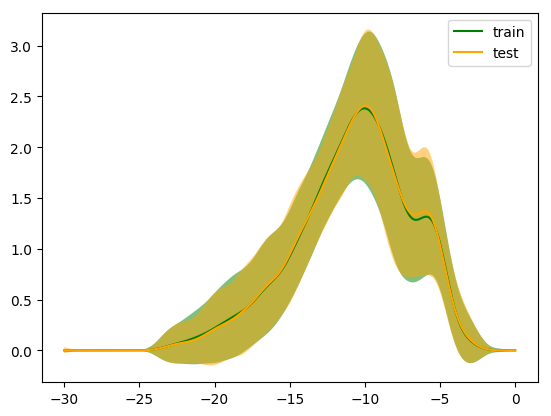

In [9]:
plot = plt.figure(1)
plot_mean_and_1std(plot, Y_train, color="green", label="train")
plot_mean_and_1std(plot, Y_test, color="orange", label="test")
plt.legend()
plt.show()

### Implementing the CNN

Here, we proceed with the CNN network and build the architecture.


We start by loading PyTorch and setting up a class for loading the data.

In [10]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import torch
import lightning.pytorch as pl
import torch.nn.functional as F
import numpy as np

# Define the Dataset class
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.x = torch.from_numpy(features).reshape(-1, 29, 29).unsqueeze(1).float()
        self.y = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {"X" : self.x[idx], "y" : self.y[idx]}

/PUHTI_TYKKY_VU7CbXh/miniconda/envs/env1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we set up a simple CNN model by defining all the functional components this AI model will need, such as:

*  network architecture (number of layers and neurons)
*  activation function type
*  functions to load training and validation data
*  training steps on training and validation data
*  optimisers for NN training

We start by defining a number of network hyperparameters that can later be adjusted.

In [11]:
# Hyperparameters for NN architecture:
# Conv2D
output_length = 300  # this is size of output
nConv = 20           # number of convolutional matrices
filter = 3           # size of filter matrix
pad = 1              # padding for the filter scan

# MaxPool2D
maxp = 4             # size of maxpool layer

# Hyperparameters for NN training:
batch = 64            # total training set is divided into batches for training
learning_rate = 1e-3  # the rate of updating the network weights during training

# Define network
class CNN(pl.LightningModule):
    def __init__(self, output_length):
        super(CNN, self).__init__()

        # Below we define 2 hidden layers (design choice)
        # followed by a MaxPool layer and a linear layer
        # convolution key parameters: no. of input and output nodes

        # 1st convolution, 1 = input matrix
        self.conv1_1 = nn.Conv2d(1, nConv, filter, padding=pad)
        # 2nd convolution
        self.conv1_2 = nn.Conv2d(nConv, nConv, filter, padding=pad)
        # 3rd convolution
        self.conv1_3 = nn.Conv2d(nConv, maxp, filter, padding=pad)
        # MaxPool - different hyperparameters apply
        self.pool = nn.MaxPool2d(maxp,maxp)
        # The linear layer size is approximately 4x7x7
        self.fc1 = nn.Linear(maxp*7*7, output_length)

    # this describes how the NN is propagated forward
    def forward(self, x, labels=None):

        # relu is used after the 1st layer
        x = F.relu(self.conv1_1(x))
        # relu is used after the 2nd layer
        x = F.relu(self.conv1_2(x))
        # relu is used after the 3rd layer
        x = F.relu(self.conv1_3(x))
        # print(x.shape)
        x = self.pool(x)
        x = x.view(-1, 4*7*7)
        outputs = self.fc1(x)

        loss = 0
        if labels is not None:
            loss = nn.functional.mse_loss(outputs.squeeze(), labels.squeeze())
        return loss, outputs

    def train_dataloader(self):
        dataset = SimpleDataset(X_train, Y_train)
        return DataLoader(dataset, batch_size=batch)

    def val_dataloader(self):
        dataset = SimpleDataset(X_val, Y_val)
        return DataLoader(dataset, batch_size=batch, num_workers=1)

    def training_step(self, batch, batch_idx):
        coloumb_matrices = batch["X"]
        energies = batch["y"]
        loss, outputs = self(coloumb_matrices, labels=energies)
        self.log("loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        coloumb_matrices = batch["X"]
        energies = batch["y"]
        loss, outputs = self(coloumb_matrices, labels=energies)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=learning_rate)
        return optimizer



## Training the CNN

In [13]:
# We set the output parameter to the entire spectral function
cnn = CNN(output_length = output_length)

# Next, we define the NN training function, which is then applied to the CNN.
# As before, we use the Early Stopping, and you can vary the epochs.
trainer = pl.Trainer(max_epochs=20, callbacks=[EarlyStopping(monitor="loss", mode="min", patience=3)])
trainer.fit(cnn)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params
--------------------------------------
0 | conv1_1 | Conv2d    | 200   
1 | conv1_2 | Conv2d    | 3.6 K 
2 | conv1_3 | Conv2d    | 724   
3 | pool    | MaxPool2d | 0     
4 | fc1     | Linear    | 59.1 K
--------------------------------------
63.6 K    Trainable params
0         Non-trainable params
63.6 K    Total params
0.255     Total estimated model params size (MB)


Epoch 0:  80%|████████  | 32/40 [00:01<00:00, 30.22it/s, loss=0.275, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|████████  | 32/40 [00:01<00:00, 29.99it/s, loss=0.551, v_num=6, val_loss=0.195]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|████████  | 32/40 [00:01<00:00, 29.82it/s, loss=0.179, v_num=6, val_loss=0.162]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|████████  | 32/40 [00:01<00:00, 30.08it/s, loss=0.156, v_num=6, val_loss=0.142]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|████████  | 32/40 [00:01<00:00, 30.17it/s, loss=0.137, v_num=6, val_loss=0.130]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|████████  | 32/40 [00:01<00:00, 29.85it/s, loss=0.127, v_num=6, val_loss=0.125]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|████████  | 32/40 [00:01<00:00, 29.60it/s, loss=0.123, v_num=6, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|████████  | 32/40 [00:01<00:00, 30.15it/s, loss=0.121, v_num=6, val_loss=0.122]
Validation: 0it [00:00, ?it/s]
Epoch 8:  80%|██

Epoch 17:  80%|████████  | 32/40 [00:01<00:00, 30.02it/s, loss=0.112, v_num=6, val_loss=0.115]
Validation: 0it [00:00, ?it/s]
Epoch 18:  80%|████████  | 32/40 [00:01<00:00, 29.94it/s, loss=0.111, v_num=6, val_loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 19:  80%|████████  | 32/40 [00:01<00:00, 29.96it/s, loss=0.110, v_num=6, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 40/40 [00:01<00:00, 26.38it/s, loss=0.109, v_num=6, val_loss=0.112]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 40/40 [00:01<00:00, 26.19it/s, loss=0.109, v_num=6, val_loss=0.112]


Let us check prediction accuracy by computing the MSE on the test set. We now have 300 prediction targets, so the result below is the joint MSE over all of them.

In [14]:
X_test = torch.Tensor(X_test).reshape(-1, 29, 29).unsqueeze(1).float()
Y_test = torch.Tensor(Y_test).float()

test_loss, Y_pred_test = cnn(X_test, Y_test)
print(test_loss)

tensor(0.1108, grad_fn=<MseLossBackward0>)


Now let's examine the quality of the predictions on individual examples. We come back to the example spectra we reviewed earlier, with index 500 and 1500, and we compute their predictions.

In [15]:
X_train_subset = torch.Tensor(X_train)[[500,1500],:].reshape(-1, 29, 29).unsqueeze(1).float()
Y_train_subset = torch.Tensor(Y_train)[[500,1500],:].float()

# Here, we compute the MSE on the two spectra only
train_loss, Y_pred_subset = cnn(X_train_subset, Y_train_subset)
print(train_loss)

tensor(0.1033, grad_fn=<MseLossBackward0>)


Spectra 500 and 1500 are now part of the training set, but we can still review the success of the predictions. What do you observe in these cases?

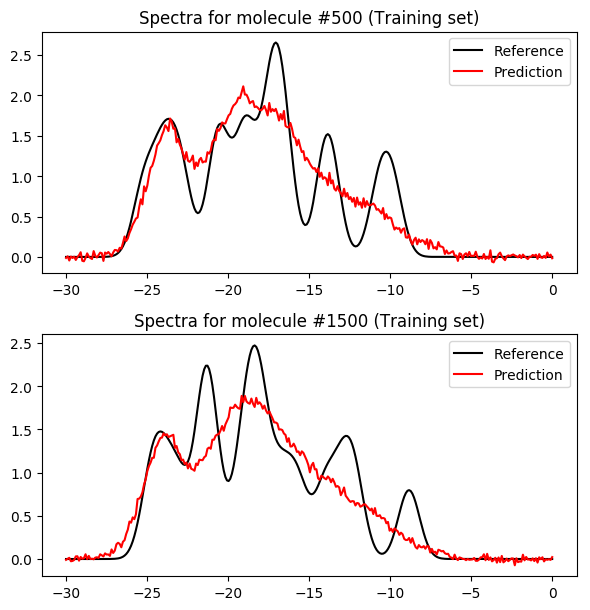

In [16]:
x_ticks = np.linspace(0,-30, 300)

plt.figure(1, figsize=(6,9))
plt.subplot(311)
plt.plot(x_ticks, Y_train_subset[0,:], color="black", label="Reference") # Molecule from training set
plt.plot(x_ticks, Y_pred_subset[0,:].detach().numpy(), color="red", label="Prediction") # Molecule from training set
plt.title("Spectra for molecule #500 (Training set)")
plt.legend()

plt.subplot(312)
plt.plot(x_ticks, Y_train_subset[1,:], color="black", label="Reference") # Molecule from training set
plt.plot(x_ticks, Y_pred_subset[1,:].detach().numpy(), color="red", label="Prediction") # Molecule from training set
plt.title("Spectra for molecule #1500 (Training set)")
plt.legend()
plt.tight_layout()

Next, let's consider a prediction on a (previously unseen) spectrum in the test set. Is the quality different than for the test set?

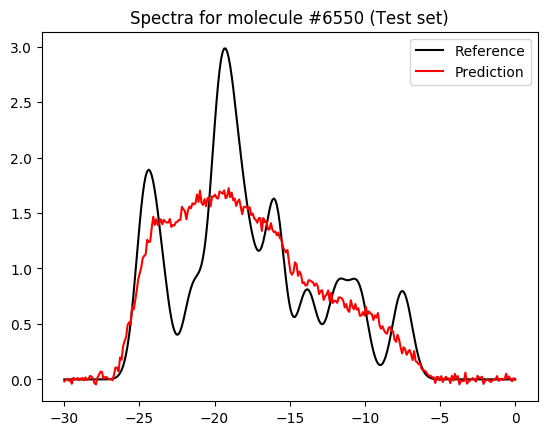

In [17]:
plt.plot(x_ticks, Y_test[50,:], color="black", label="Reference")
plt.plot(x_ticks, Y_pred_test[50,:].detach().numpy(), color="red", label="Prediction")
plt.title("Spectra for molecule #6550 (Test set)")
plt.legend()
#plt.tight_layout()